In [362]:
import numpy as np
from numpy.random import RandomState
import matplotlib.pyplot as plt
from numpy import sqrt
from numpy import exp
from numpy import log

Let the likelihood be normally distributed with known variance, specifically we have 

$L(\theta) = \prod_{i=1}^n p(x_i | \theta)$ and $p(x|\theta)$ is the density of a normal distribution with mean $\theta$ and variance $\sigma^2$. Furthermore, we let $\theta$ have a normal prior. Assuming $n$ is large, we can say that the posterior will converge to a normal distribution. We can show this by taking the Taylor series expansion around the posterior mode $\mu_\theta$, and assuming we know the posterior variance $\sigma_\theta$ (this is usually a function of $\mu_\theta$) we have our optimisation objective

$\text{min}_{\mu_\lambda,\sigma_\lambda}$ $\mathbb{E}_q\left[\frac{(\theta - \mu_\theta)^2}{2\sigma_\theta^2}\right]$ where $q\sim \mathcal{N}(\mu_\lambda,\sigma_\lambda)$

We now seek to evaluate the gradient and the variance of the gradient for this optimisation objective and see if the variance of the score function method dominates the variance of the RP trick estimate of the gradient.

In [363]:
#set posterior mode
mu_t = 5
sigma_t = 2

#randomly initialise parameters
prng_m = RandomState(5)
prng_s = RandomState(12)

mu_l_0 = prng_m.uniform(0,10)
sigma_l_0 = prng_s.uniform(0,10)

print("initial mu: ", mu_l_0, "initial sigma: ", sigma_l_0)

#score function
def f(x,mu_t,sigma_t):
    return (x-mu_t)**2/(2*sigma_t**2)

def q_grad(x,mu_t,sigma_t,mu_l,sigma_l):
    q_g = np.zeros([2,x.size])
    q_g[0]=(x-mu_l)/sigma_l**2
    q_g[1]=-1/sigma_l+(x-mu_l)**2/sigma_l**3
    return q_g

def score_grad(x,mu_t,sigma_t,mu_l,sigma_l):
    return f(x,mu_t,sigma_t)*q_grad(x,mu_t,sigma_t,mu_l,sigma_l)

#reparameterisation trick
def f_d(x,mu_t,sigma_t):
    return (x-mu_t)/sigma_t**2

def T(z,m,s):
    return m+z*s

def T_inv(x,m,s):
    return (x-m)/s

def T_grad(z,m,s):
    T_g = np.zeros([2,z.size])
    T_g[0] = np.ones(z.size)
    T_g[1] = z
    return T_g

def rp_grad(z,mu_t,sigma_t,mu_l,sigma_l):
    return f_d(T(z,mu_l,sigma_l),mu_t,sigma_t,)*T_grad(z,mu_l,sigma_l)

#evaluate optimisation objective
def obj(mu_t,sigma_t,mu_l,sigma_l):
    return 1/(2*sigma_t**2)*(mu_l**2+sigma_l**2-2*mu_l*mu_t+mu_t**2)

initial mu:  2.219931710897395 initial sigma:  1.5416284237967237


First, given the initial parameter initalisations above, we simulate the gradient under both the score function method and RP trick and investigate.

In [364]:
#investigate the variance for the initial parameter estimates
prng1 = RandomState(27) 
samples_rp = prng1.normal(0,1,100)
samples = samples_rp*sigma_l_0+mu_l_0

d = score_grad(samples,mu_t,sigma_t,mu_l_0,sigma_l_0)
e = rp_grad(samples_rp,mu_t,sigma_t,mu_l_0,sigma_l_0)

print("Score variance: ", np.var(d,axis=1),"RP variance: ",np.var(e,axis=1))

Score variance:  [ 1.88318122  6.35185309] RP variance:  [ 0.11906711  0.59834799]


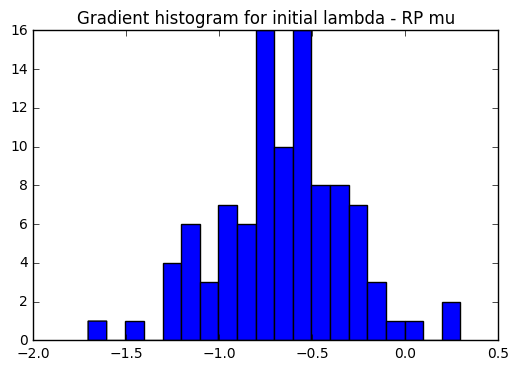

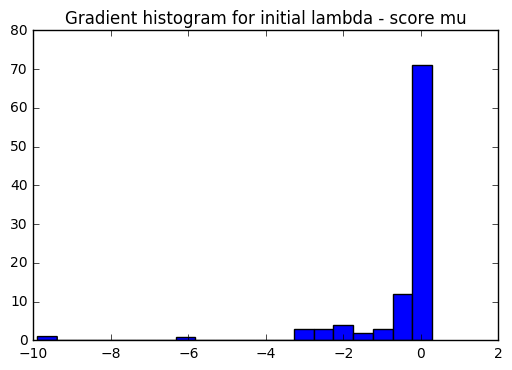

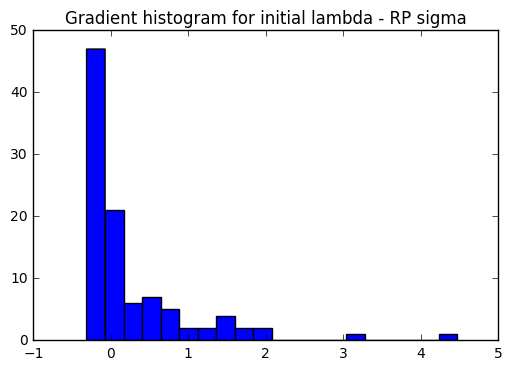

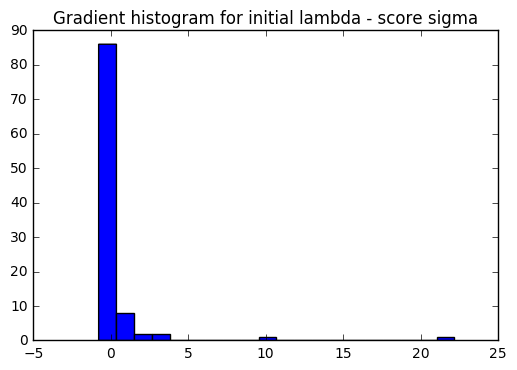

In [365]:
#histogram 
plt.title("Gradient histogram for initial lambda - RP mu")
plt.hist(e[0],bins=20)
plt.show()

plt.title("Gradient histogram for initial lambda - score mu")
plt.hist(d[0],bins=20)
plt.show()

plt.title("Gradient histogram for initial lambda - RP sigma")
plt.hist(e[1],bins=20)
plt.show()

plt.title("Gradient histogram for initial lambda - score sigma")
plt.hist(d[1],bins=20)
plt.show()

As the above sample variance and histograms suggest, the variance for the RP trick is much lower for the initial conditions. We now perform the actual optimisation and minimise the objective above w.r.t. the variational parameters.

Final mu (score):  7.31909699592 Final sigma (score):  0.0227482568662


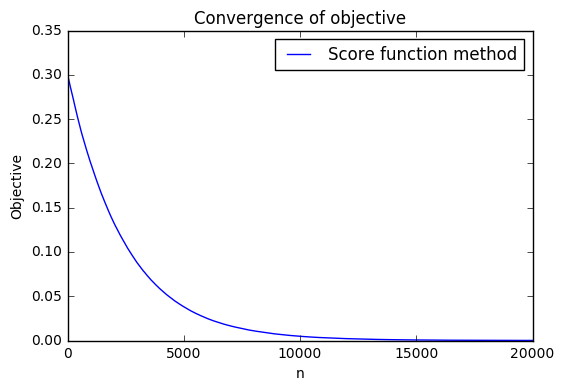

In [382]:
#implement score function method to update variational parameters
n_iter = 20000
n_samples = 100
l = 0.01

#initialise parameters
mu_l = mu_l_0
sigma_l = sigma_l_0

#initialise vectors to store output
grad_var = np.zeros([2,n_iter])
f_vec = np.zeros(n_iter)
params_vec = np.zeros([2,n_iter])

#perform gradient descent
for i in range(0,n_iter):
    #random samples from q
    s = np.random.normal(mu_l,sigma_l,n_samples)
    #evaluate MC estimate of gradient
    g_vec = score_grad(s,mu_t,sigma_t,mu_l,sigma_l)
    g = np.mean(g_vec, axis=1)
    #variance of gradient estimate
    var = np.var(g_vec, axis=1)
    grad_var[0,i] = var[0]
    grad_var[1,i] = var[1]
    #store current parameters with variance for comparison
    params_vec[0,i]=mu_l
    params_vec[1,i]=sigma_l
    #store optimisation objective
    f_vec[i]=obj(mu_t,sigma_t,mu_l,sigma_l)
    #update parameters
    mu_l = mu_l-l*g[0]
    sigma_l = sigma_l-l*g[1]
    
print("Final mu (score): ", mu_l, "Final sigma (score): ", sigma_l)
#check convergence of objective
plt.plot(np.linspace(1,n_iter,n_iter), f_vec, label='Score function method')
plt.ylabel('Objective')
plt.xlabel('n')
plt.legend()
plt.title('Convergence of objective')
plt.show()


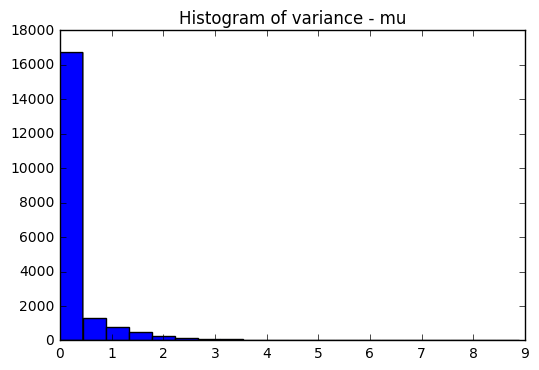

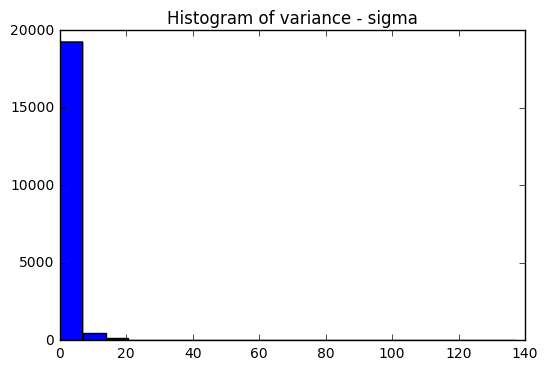

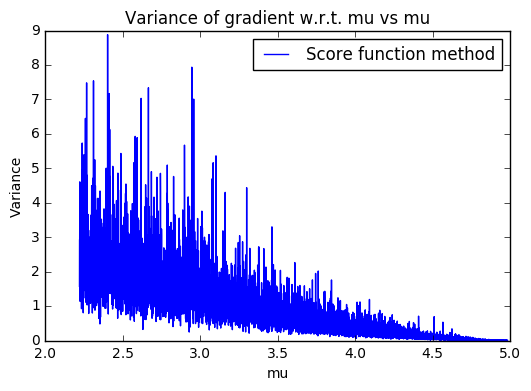

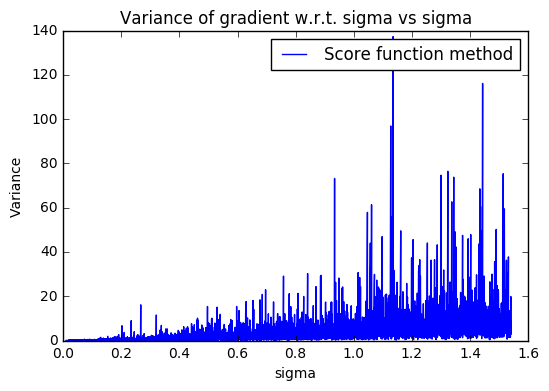

In [367]:
#plot histogram of variance of gradient estimates
plt.title("Histogram of variance - mu")
plt.hist(grad_var[0],bins=20)
plt.show()

plt.title("Histogram of variance - sigma")
plt.hist(grad_var[1],bins=20)
plt.show()

#plot variance of gradient against mu
plt.plot(params_vec[0], grad_var[0], label='Score function method')
plt.ylabel('Variance')
plt.xlabel('mu')
plt.legend()
plt.title('Variance of gradient w.r.t. mu vs mu')
plt.show()

#plot variance of gradient against mu
plt.plot(params_vec[1], grad_var[1], label='Score function method')
plt.ylabel('Variance')
plt.xlabel('sigma')
plt.legend()
plt.title('Variance of gradient w.r.t. sigma vs sigma')
plt.show()

Evidently, the variance of the gradient w.r.t. $\mu_\lambda$ decreases (on average) as it gets closer to the objective ($\mu_\theta$). In addition, occasionally the variance of the gradient estimate is extremely high. The same can be said as $\sigma_\lambda\rightarrow 0$ which is the optimal value for $\sigma_\lambda$.

Final mu (RP):  4.9812179153 Final sigma (RP):  0.0105366804429


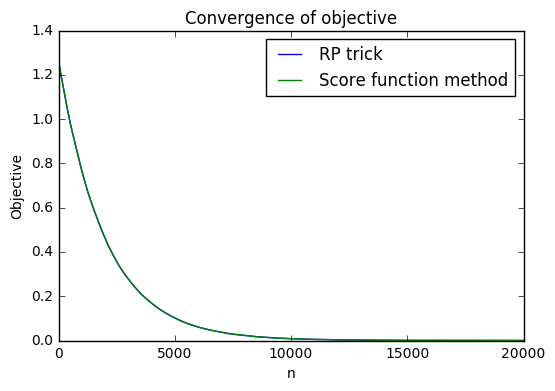

In [368]:
#implement RP trick to update variational parameters

#initialise parameters in the same location
mu_l = mu_l_0
sigma_l = sigma_l_0

#initialise vectors for output
grad_var_rp = np.zeros([2,n_iter])
f_vec_rp = np.zeros(n_iter)
params_vec_rp = np.zeros([2,n_iter])

for i in range(0,n_iter):
    #random samples from e
    s = np.random.normal(0,1,n_samples)
    #evaluate MC estimate of gradient
    g_vec = rp_grad(s,mu_t,sigma_t,mu_l,sigma_l)
    g = np.mean(g_vec, axis=1)
    #variance of gradient estimate
    var = np.var(g_vec, axis=1)
    grad_var_rp[0,i] = var[0]
    grad_var_rp[1,i] = var[1]
    #store current parameters with variance for comparison
    params_vec_rp[0,i]=mu_l
    params_vec_rp[1,i]=sigma_l
    #store optimisation objective
    f_vec_rp[i]=obj(mu_t,sigma_t,mu_l,sigma_l)
    #update parameters
    mu_l = mu_l-l*g[0]
    sigma_l = sigma_l-l*g[1]
    
print("Final mu (RP): ", mu_l, "Final sigma (RP): ", sigma_l)
#check convergence of objective
plt.plot(np.linspace(1,n_iter,n_iter), f_vec, label='RP trick')
plt.plot(np.linspace(1,n_iter,n_iter), f_vec, label='Score function method')
plt.ylabel('Objective')
plt.xlabel('n')
plt.legend()
plt.title('Convergence of objective')
plt.show()

Objective function converges the same under both methods.

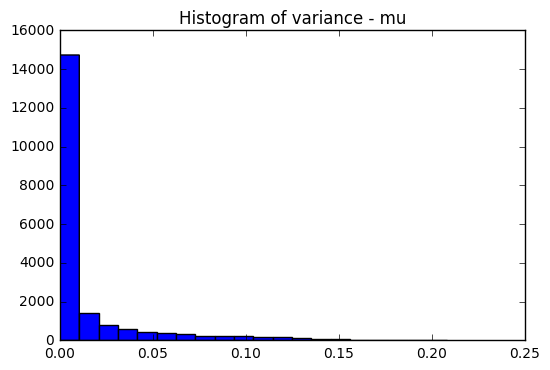

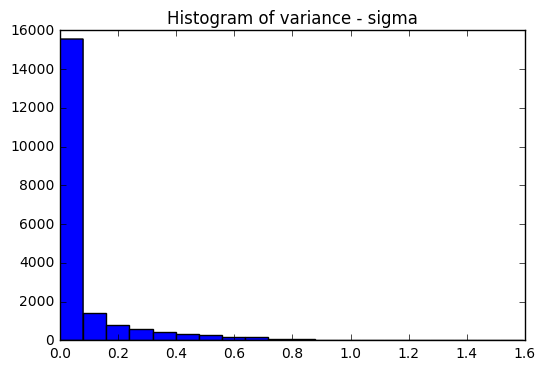

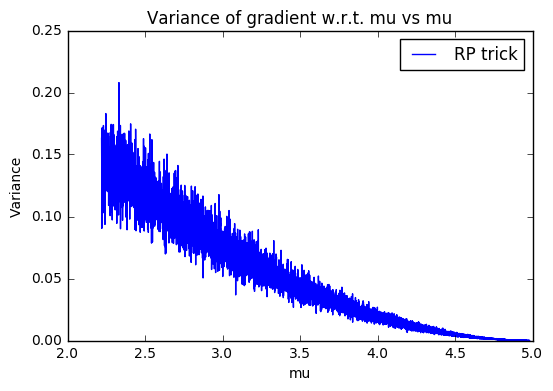

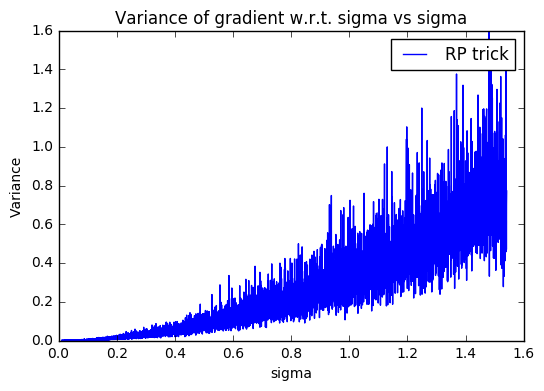

In [369]:
#plot histogram of variance of gradient estimates
plt.title("Histogram of variance - mu")
plt.hist(grad_var_rp[0],bins=20)
plt.show()

plt.title("Histogram of variance - sigma")
plt.hist(grad_var_rp[1],bins=20)
plt.show()

#plot variance of gradient against mu
plt.plot(params_vec_rp[0], grad_var_rp[0], label='RP trick')
plt.ylabel('Variance')
plt.xlabel('mu')
plt.legend()
plt.title('Variance of gradient w.r.t. mu vs mu')
plt.show()

#plot variance of gradient against mu
plt.plot(params_vec_rp[1], grad_var_rp[1], label='RP trick')
plt.ylabel('Variance')
plt.xlabel('sigma')
plt.legend()
plt.title('Variance of gradient w.r.t. sigma vs sigma')
plt.show()

It appears that the RP trick yields much smaller variance estimates on average, however convergence by iteration appears to be slower.

Next, given the posterior mode and variance set globally near the top of the page, we simulate values of $\mu_\lambda$ and $\sigma_\lambda$ uniformly from a grid. For each pair of samples, I simulate the gradient for that given point and estimate the variance of the gradient (using the sample variance) under the RP trick and the score function method. I then look for any points where the RP trick yields higher variance.

The number of points appears to decrease as the number of samples increases unsurprisingly.

In [370]:
n1 = 10000 #number variational parameter samples
#sample variational parameter values from grid
sims = np.random.uniform(-10,10,[2,n1]) 
sims[1] = np.random.uniform(0,10,n1)
n2 = 1000 #number of samples of gradient

#initialise matrices for storing variance estimates
var_vec_sc = np.zeros([2,n1])
var_vec_rp = np.zeros([2,n1])
#initialises matrix for storing parameter samples
params_vec = np.zeros([2,n1])

for i in range(0,n1):
    #extract parameters
    mu_l = sims[0,i]
    sigma_l = sims[1,i]
    #simulate gradient
    s1 = np.random.normal(0,1,n2)
    g_vec_rp2 = rp_grad(s1,mu_t,sigma_t,mu_l,sigma_l)
    g_vec_score2 = score_grad(s1*sigma_l+mu_l,mu_t,sigma_t,mu_l,sigma_l)
    #estimate variance
    var = np.var(g_vec_score2,axis=1)
    var2 = np.var(g_vec_rp2,axis=1)
    #store variance under both methods
    var_vec_sc[0,i] = var[0]
    var_vec_sc[1,i] = var[1]
    var_vec_rp[0,i] = var2[0]
    var_vec_rp[1,i] = var2[1]
    #store corresponding parameters
    params_vec[0,i] = mu_l
    params_vec[1,i] = sigma_l

#calculate ratio of variance under score to RP for comparison
ratio_var = var_vec_sc/var_vec_rp

[ 2.17339157  3.60169094]
[  1.30996115e+15   4.55069715e+07]
[  1.53429531e+11   8.34117272e+03]


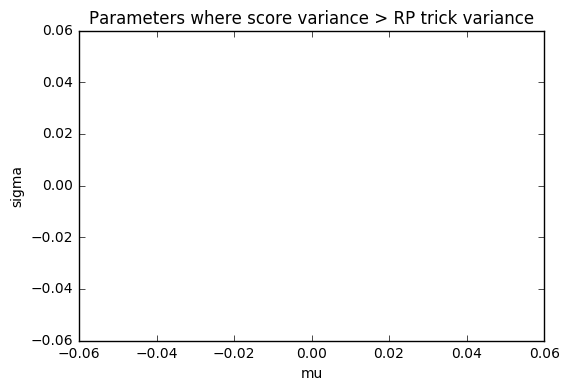

In [371]:
#summary statistics for ratios
print(np.min(ratio_var,axis=1))
print(np.max(ratio_var,axis=1))
print(np.mean(ratio_var,axis=1))

#find all parameter combinations where the ratio is <1 for both mu and sigma
loc1 = np.where(ratio_var[0]<1)
loc2 = np.where(ratio_var[1]<1)
loc = np.concatenate((loc1, loc2),axis=1)

#plot parameters in parameter space where discrepancies are found
plt.title("Parameters where score variance > RP trick variance")
plt.ylabel('sigma')
plt.xlabel('mu')
plt.scatter(params_vec[0,loc],params_vec[1,loc])
plt.show()

The section below seeks to calculate the analytical estimate of the variance of the gradient estimator for a given set of variational parameters and posterior mode/variance. The variance depends on $\mu_\theta,\sigma_\theta,\mu_\lambda,\sigma_\lambda$ and so we will calculate the analytical variance for each method as a function of these four variables. Using this, we will simulate uniformly from a grid in the parameter space of these four variables and will identify any instances where the variance for the RP trick is lower than in the score function method.

In [372]:
#calculates moments of normal distribution given parameters
def E_8(m,s):
    return m**8+28*m**6*s**2+210*m**4*s**4+420*m**2*s**6+105*s**8

def E_7(m,s):
    return m**7+21*m**5*s**2+105*m**3*s**4+105*m*s**6

def E_6(m,s):
    return m**6+15*m**4*s**2+45*m**2*s**4+15*s**6

def E_5(m,s):
    return m**5+10*m**3*s**2+15*m*s**4

def E_4(m,s):
    return m**4+6*m**2*s**2+3*s**4

def E_3(m,s):
    return m**3+3*m*s**2

def E_2(m,s):
    return m**2+s**2

#analytical estimate of variance under score function method
def var_score(params):
    #params
    mu_t = params[0]; sigma_t = params[1]; mu_l = params[2]; sigma_l = params[3]
    var = np.zeros(2)
    #1st/2nd moment for gradient wrt mu
    b = -2*mu_t-mu_l
    c = 2*mu_t*mu_l+mu_t**2
    #first and second moments to eval variance w.r.t. mu
    m2 = E_6(mu_l,sigma_l)+2*b*E_5(mu_l,sigma_l)+(2*c+b**2)*E_4(mu_l,sigma_l)+2*b*c*E_3(mu_l,sigma_l)+c**2*E_2(mu_l,sigma_l)
    m1 = E_3(mu_l,sigma_l)+b*E_2(mu_l,sigma_l)+c*mu_l
    var[0]=1/(4*sigma_t**4*sigma_l**4)*(m2-m1**2)
    #variance w.r.t. sigma
    a = 1/sigma_l**3
    b = -2*(mu_l+mu_t)/sigma_l**3
    c = (mu_l**2+4*mu_t*mu_l+mu_t**2)/sigma_l**3-1/sigma_l
    d = -2*(mu_t*mu_l**2+mu_t**2*mu_l)/sigma_l**3+2*mu_t/sigma_l
    #moments
    m2 = a**2*E_8(mu_l,sigma_l)+2*a*b*E_7(mu_l,sigma_l)+(2*a*c+b**2)*E_6(mu_l,sigma_l)+2*(a*d+b*c)*E_5(mu_l,sigma_l)+ \
        (2*b*d+c**2)*E_4(mu_l,sigma_l)+2*c*d*E_3(mu_l,sigma_l)+d**2*E_2(mu_l,sigma_l)
    m1 = a*E_4(mu_l,sigma_l)+b*E_3(mu_l,sigma_l)+c*E_2(mu_l,sigma_l)+d*mu_l
    var[1]=1/(4*sigma_t**4)*(m2-m1**2)
    return var

#analytical estimate of variance under RP trick
def var_rp(params):
    #params
    mu_t = params[0]; sigma_t = params[1]; mu_l = params[2]; sigma_l = params[3]
    var = np.zeros(2)
    var[0] = sigma_l**2
    #variance of sigma_l
    a = sigma_l; b = mu_l-mu_t
    var[1] = 2*a**2+b**2
    return 1/sigma_t**4*var

#uniformly simulate from grid in parameter space for all 4 parameters
nsims = 5000000
sims1 = np.random.uniform(-10,10,[4,nsims])
#make sigmas non-negative
sims1[1] = np.random.uniform(0,10,nsims)
sims1[3] = np.random.uniform(0,10,nsims)
sims1 = np.transpose(sims1)

#initialise vector to store variances of the gradient w.r.t. mu and sigma for both the score function and RP trick
var_vec = np.zeros([4,nsims])

#simulate from parameter space and eval variance
for i in range(0,nsims):
    sc = var_score(sims1[i])
    rp = var_rp(sims1[i])
    var_vec[0,i] = sc[0]; var_vec[1,i] = sc[1]
    var_vec[2,i] = rp[0]; var_vec[3,i] = rp[1]

In [373]:
#identify point in param space where score < RP trick
sc_gt = np.where(var_vec[0] < var_vec[2])
sc_gt2 = np.where(var_vec[1] < var_vec[3])
sc_gt3 = np.concatenate((sc_gt, sc_gt2),axis=1)
sims_gt = sims1[sc_gt3]
sims_gt = sims_gt[0]

#show number of points
print("Number of samples where variance of Score < RP: ", np.shape(sims_gt)[0])
print("Percentage of total samples: ",np.shape(sims_gt)[0]/nsims)

Number of samples where variance of Score < RP:  852
Percentage of total samples:  0.0001704


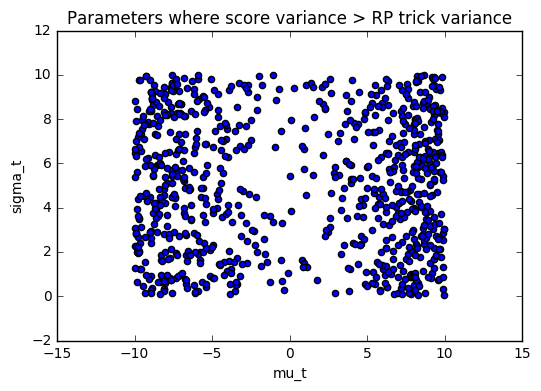

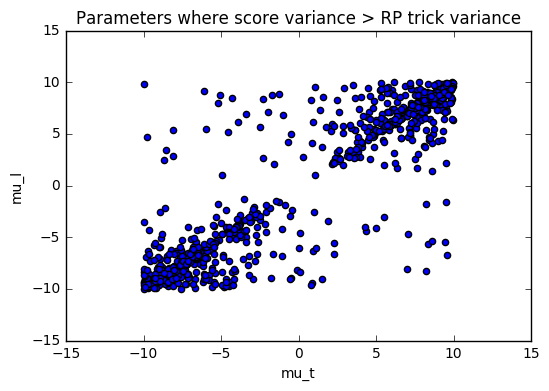

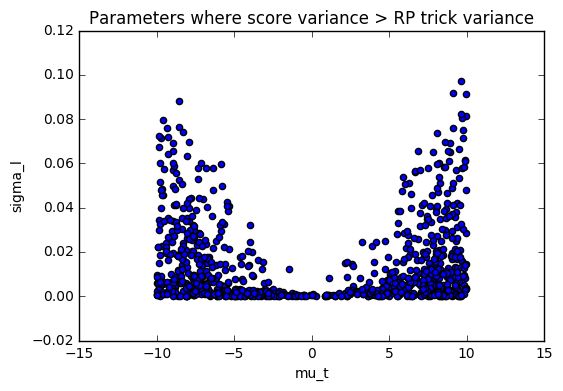

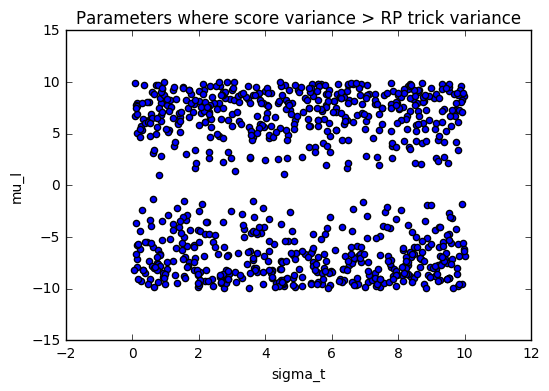

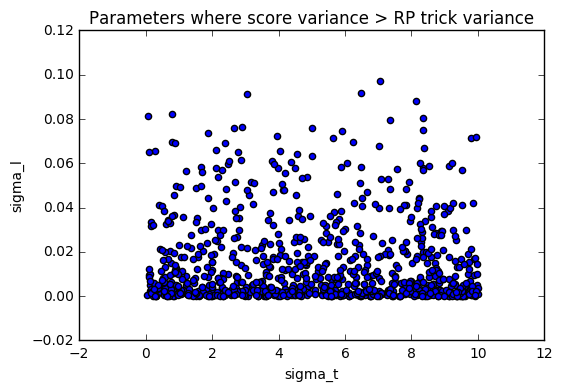

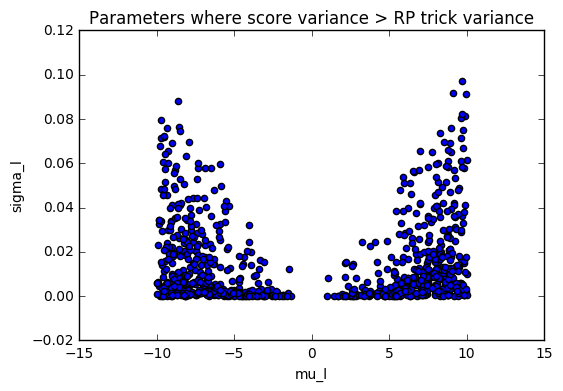

In [374]:
#transpose for visualisation of parameter space
sims_gt_t = np.transpose(sims_gt)

#plot parameters in parameter space where discrepancies are found
plt.title("Parameters where score variance > RP trick variance")
plt.ylabel('sigma_t')
plt.xlabel('mu_t')
plt.scatter(sims_gt_t[0],sims_gt_t[1])
plt.show()

#plot parameters in parameter space where discrepancies are found
plt.title("Parameters where score variance > RP trick variance")
plt.ylabel('mu_l')
plt.xlabel('mu_t')
plt.scatter(sims_gt_t[0],sims_gt_t[2])
plt.show()

#plot parameters in parameter space where discrepancies are found
plt.title("Parameters where score variance > RP trick variance")
plt.ylabel('sigma_l')
plt.xlabel('mu_t')
plt.scatter(sims_gt_t[0],sims_gt_t[3])
plt.show()

#plot parameters in parameter space where discrepancies are found
plt.title("Parameters where score variance > RP trick variance")
plt.ylabel('mu_l')
plt.xlabel('sigma_t')
plt.scatter(sims_gt_t[1],sims_gt_t[2])
plt.show()

#plot parameters in parameter space where discrepancies are found
plt.title("Parameters where score variance > RP trick variance")
plt.ylabel('sigma_l')
plt.xlabel('sigma_t')
plt.scatter(sims_gt_t[1],sims_gt_t[3])
plt.show()

#plot parameters in parameter space where discrepancies are found
plt.title("Parameters where score variance > RP trick variance")
plt.ylabel('sigma_l')
plt.xlabel('mu_l')
plt.scatter(sims_gt_t[2],sims_gt_t[3])
plt.show()


Taking the 2d cross sections of the parameter space, nothing immediately useful comes in identifying why the variance for the score < variance of RP. There are some concentrations near 0 for the $\sigma$ values but otherwise nothing noticable.

In [375]:
#analysis of point in parameter space where variance of score < RP
sim = sims_gt[722]

print("var_sc: ", var_score(sim))
print("var_rp: ", var_rp(sim))
print("params: ", sim)

p = sim
mu_t = p[0]; sigma_t = p[1]; mu_l = p[2]; sigma_l = p[3]
s = np.random.normal(0, 1, 100000)
s1 = s*sigma_l + mu_l
sc = score_grad(s1,mu_t,sigma_t,mu_l,sigma_l)
rp = rp_grad(s,mu_t,sigma_t,mu_l,sigma_l)

print("Sample variance (score): ", np.var(sc,axis=1))
print("Sample variance (RP): ", np.var(rp,axis=1))

var_sc:  [ 0.00010584 -0.00219139]
var_rp:  [  2.68316930e-08   3.23975004e-06]
params:  [ 4.03871842  9.74343204  4.20817277  0.01555063]
Sample variance (score):  [ 0.00010631  0.00024197]
Sample variance (RP):  [  2.68706739e-08   3.24877215e-06]


Note that the analytical variance under the score function approach is negative here, however simulation reveals that is not the case.

In [376]:
#analysis of simulation (any) to check that sample variance -> analytical
sim = sims1[500]

print("var_sc: ", var_score(sim))
print("var_rp: ", var_rp(sim))
print("params: ", sim)

p = sim
mu_t = p[0]; sigma_t = p[1]; mu_l = p[2]; sigma_l = p[3]
s = np.random.normal(0, 1, 100000)
s1 = sigma_l*s+mu_l
sc = score_grad(s1,mu_t,sigma_t,mu_l,sigma_l)
rp = rp_grad(s,mu_t,sigma_t,mu_l,sigma_l)

print("Sample variance (score): ", np.var(sc,axis=1))
print("Sample variance (RP): ", np.var(rp,axis=1))

var_sc:  [  27.96309601  134.46338705]
var_rp:  [  6.09954994  13.62936809]
params:  [-1.9095553   1.89582454  2.38882684  8.87656987]
Sample variance (score):  [  27.45159488  128.50908412]
Sample variance (RP):  [  6.12136973  13.4981667 ]


I took the ~900 points in the parameter space which yielded negative variance under the analytical approach and performed simulations of the gradient at each point. I then compared the variance of the RP trick vs the score function approach to see which is larger.

In [377]:
#initialise matrices for storing variance estimates
var_vec_sc2 = np.zeros([2,np.shape(sims_gt)[0]])
var_vec_rp2 = np.zeros([2,np.shape(sims_gt)[0]])

for i in range(0,np.shape(sims_gt)[0]):
    #extract parameters
    params = sims_gt[i]
    mu_t = params[0]; sigma_t = params[1]; mu_l = params[2]; sigma_l = params[3]
    #simulate gradient
    s1 = np.random.normal(0,1,n2)
    g_vec_rp2 = rp_grad(s1,mu_t,sigma_t,mu_l,sigma_l)
    g_vec_score2 = score_grad(s1*sigma_l+mu_l,mu_t,sigma_t,mu_l,sigma_l)
    #estimate variance
    var = np.var(g_vec_score2,axis=1)
    var2 = np.var(g_vec_rp2,axis=1)
    #store variance under both methods
    var_vec_sc2[0,i] = var[0]
    var_vec_sc2[1,i] = var[1]
    var_vec_rp2[0,i] = var2[0]
    var_vec_rp2[1,i] = var2[1]


In [378]:
#identify point in param space where score < RP trick (those which yield)
sc_gt_a = np.where(var_vec_sc2[0] < var_vec_rp2[0])
sc_gt_a2 = np.where(var_vec_sc2[1] < var_vec_rp2[1])
sc_gt_a3 = np.concatenate((sc_gt_a, sc_gt_a2),axis=1)
sims_gt2 = sims_gt_t[sc_gt_a3]

print(sims_gt2)

[]


From this it appears none of the sampled variances are larger for the RP trick compared to the score function method.